In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy

In [3]:
DATA_DIR = "/kaggle/input/rice-grain-grading/Grading_augmented_dataset"  # Update with actual dataset path

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.4,
    brightness_range=(0.7, 1.3),
    shear_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [5]:
train_data = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle= True
    )

val_data = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle= False
    )

Found 2032 images belonging to 3 classes.
Found 508 images belonging to 3 classes.


In [6]:
print("\nClass Indices:")
print(train_data.class_indices)


Class Indices:
{'Average': 0, 'Bad': 1, 'Good': 2}


In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [8]:
input_layer = Input(shape=(380, 380, 3))
efficient_net = EfficientNetB4(include_top=False, weights='imagenet', input_tensor=input_layer)

for layer in efficient_net.layers:
    layer.trainable = False

for layer in efficient_net.layers[-100:]:  
    layer.trainable = True

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [9]:
x = efficient_net.output
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 380, 380, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 380, 380, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 380, 380, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 380, 380, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 381, 381, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 190, 190, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 190, 190, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 190, 190, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 190, 190, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 190, 190, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 190, 190, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 23,383,906 (89.20 MB)

 Trainable params: 16,288,843 (62.14 MB)

 Non-trainable params: 7,095,063 (27.07 MB)

In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.00001),  
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_rice_quality_model.keras", save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

In [11]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3346 - loss: 1.9992
Epoch 1: val_accuracy improved from -inf to 0.43307, saving model to best_rice_quality_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.3346 - loss: 1.9988 - val_accuracy: 0.4331 - val_loss: 1.0886 - learning_rate: 1.0000e-05
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3371 - loss: 1.9170
Epoch 2: val_accuracy did not improve from 0.43307
64/64 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - accuracy: 0.3371 - loss: 1.9168 - val_accuracy: 0.4331 - val_loss: 1.0893 - learning_rate: 1.0000e-05
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3422 - loss: 1.9003
Epoch 3: val_accuracy did not improve from 0.43307
64/64 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.3421 - loss: 1.9007 - val_accuracy: 0.4331 - val_loss: 1.0926 - learning_rate: 1.0000e-05
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3608 - loss: 1.8433
Epoch 4: val_accuracy did not improve from 0.4

In [12]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.2025 - loss: 1.7407
Validation Loss: 1.6410, Validation Accuracy: 0.2362


In [13]:
from tensorflow.keras.models import load_model

model_path = "best_rice_quality_model.keras"

model = load_model(model_path)

model.summary()

Model: "functional"

 Total params: 55,961,594 (213.48 MB)

 Trainable params: 16,288,843 (62.14 MB)

 Non-trainable params: 7,095,063 (27.07 MB)

 Optimizer params: 32,577,688 (124.27 MB)

In [14]:
model.save("final_rice_quality_model.keras")
print("Final model saved successfully.")

Final model saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


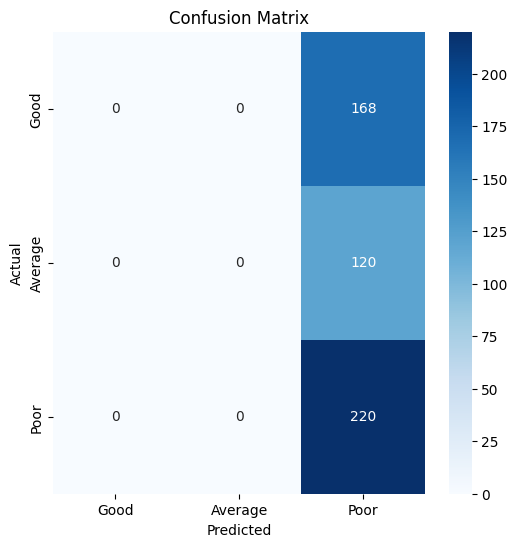

In [20]:
y_true = []
y_pred = []
class_labels = ['Good', 'Average', 'Poor']

for images, labels in val_data:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_data.samples:
        break

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00       168
     Average       0.00      0.00      0.00       120
        Poor       0.43      1.00      0.60       220

    accuracy                           0.43       508
   macro avg       0.14      0.33      0.20       508
weighted avg       0.19      0.43      0.26       508



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Enter image index (0 to 507):  45


Selected image path: /kaggle/input/rice-grain-grading/Grading_augmented_dataset/Average/IMG20250325122353_BURST008_90.jpg


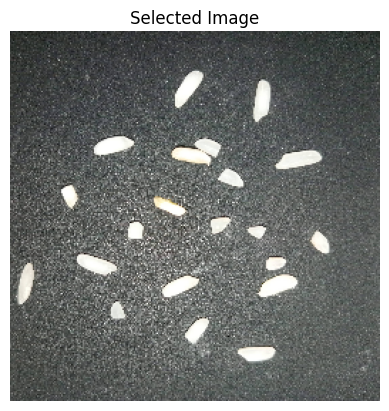

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 380, 380, 3), found shape=(1, 260, 260, 3)

In [16]:
import tensorflow as tf
def predict_quality_from_index(model, val_data):
    class_labels = list(val_data.class_indices.keys())
    index = int(input(f"Enter image index (0 to {len(val_data.filepaths) - 1}): "))
    image_path = val_data.filepaths[index]
    print(f"Selected image path: {image_path}")

    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(260, 260))
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    plt.imshow(image)
    plt.axis('off')
    plt.title("Selected Image")
    plt.show()

    prediction = model.predict(image_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    print(f"Prediction: {predicted_class} ({confidence:.2f}% confidence)")
    return predicted_class

print("Predicted Quality:", predict_quality_from_index(model, val_data))